In [1]:
import symd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
def run_sim(n, cell, group, w=None, retries=5, pos_period=0):
    for _ in range(retries):
        try:
            md = symd.Symd(nparticles=n, cell=cell, ndims=2, images=2, force='lj', wyckoffs=w,
              group=group, steps=30000, exeDir='sim', start_temperature=0.5)
            md.remove_overlap()
            md.shrink()
            if pos_period > 0:
                md.log_positions(frames=pos_period)
            md.log_output(frames=1000)
            md.run()
            break
        except RuntimeError as e:
            print(e)            
    return md

In [3]:
md = run_sim(5, [10, 10], 1)

Shrunk from 100.095 to 100.647
New cell: [9.93149, 0.0, 0.0, 9.89814]


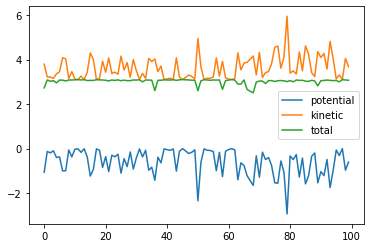

In [4]:
plt.plot(md.pe, label='potential')
plt.plot(md.ke, label='kinetic')
plt.plot(md.te, label='total')
plt.legend(loc='best')

## All Sims

In [5]:
titles = ['p1', 'p2', 'pm', 'pg', 'cm', 'pmm', 'pmg', 'pgg', 'cmm', 'p4', 'p4m', 'p4g', 'p3', 'p3m1', 'p31m', 'p6', 'p6m']
df = pd.DataFrame()
retries = 3
def smooth(x):
    window = ceil(len(x) / 10.0)
    weights = np.ones(window)
    energy_smooth = np.convolve(
        weights / weights.sum(), x[(start_index - window + 1):], mode="valid"
    )
    return 

def standardize(te):
    i = int(md.te.shape[0] * 0.2)
    te = md.te[i:]
    return te - np.mean(te)
for i,t in enumerate(titles):
    md = run_sim(4, [20, 20], i+1)
    df = df.assign(**{t: standardize(md.te)})
    print(t)
    wycks = len(symd.groups.load_group(i+1, 2)['specpos'])
    for j in range(wycks):
        md = run_sim(4+j+1, [20+j, 20+j], i+1, w=[1] * (j+1))
        name = f'{t}-w{j}'
        df = df.assign(**{name: standardize(md.te)})
        print(name)


Shrunk from 400.268 to 328.044
New cell: [18.1382, 0.0, 0.0, 17.8675]
p1
Shrunk from 400.268 to 333.915
New cell: [18.1363, 0.0, 0.0, 18.1819]
p2
Shrunk from 400.379 to 347.537
New cell: [18.5814, 0.0, 0.0, 18.2073]
p2-w0
Shrunk from 440.77 to 363.81
New cell: [18.8137, 0.0, 0.0, 19.2977]
p2-w1
Shrunk from 484.203 to 385.061
New cell: [20.2841, 0.0, 0.0, 18.8499]
p2-w2
Shrunk from 528.881 to 413.707
New cell: [19.8315, 0.0, 0.0, 20.7247]
p2-w3
Shrunk from 400.268 to 328.477
New cell: [18.0859, 0.0, 0.0, 17.9877]
pm
Shrunk from 400.379 to 347.711
New cell: [18.4994, 0.0, 0.0, 18.2971]
pm-w0
Shrunk from 440.77 to 367.216
New cell: [19.0085, 0.0, 0.0, 19.2728]
pm-w1
Shrunk from 400.268 to 326.49
New cell: [18.1289, 0.0, 0.0, 17.7337]
pg
Shrunk from 400.268 to 329.547
New cell: [18.1203, 0.0, 0.0, 17.9777]
cm
Shrunk from 400.379 to 350.544
New cell: [18.6569, 0.0, 0.0, 18.2855]
cm-w0
Shrunk from 400.268 to 329.476
New cell: [18.0936, 0.0, 0.0, 18.0059]
pmm
Shrunk from 400.379 to 350.362
Ne

{"steps": 1000, "n_particles": 5, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 10, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 3, "skin": 0.6000000000000001, "temperature": 0.01, "pressure": null, "box_update_period": 0, "start_temperature": 0.01, "thermostat": "baoab", "force_type": "lj", "final_positions": "sim/group-12.xyz", "cell_log_file": "sim/cell_log_file.dat", "print_period": 300.0, "cell": [20, 20], "lj_epsilon": 1, "lj_sigma": 1.0, "n_images": 2, "start_positions": "sim/group-12.xyz", "group": "sim/group-12.json", "wyckoffs": [{"group": "sim/group-12-00.json", "n_particles": 1}]}
Info: You are running version 94e9-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-12 with 4 particles and 8 members
Info: Loaded group group-12-0 with 1 particles and 4 members
Info: Duplicating 5 particles into 5 real particles and 895 ghost for group with 8 elements and 24 tilings. Each cell has 36 particles.
Info:

ValueError: Length of values (4) does not match length of index (80)

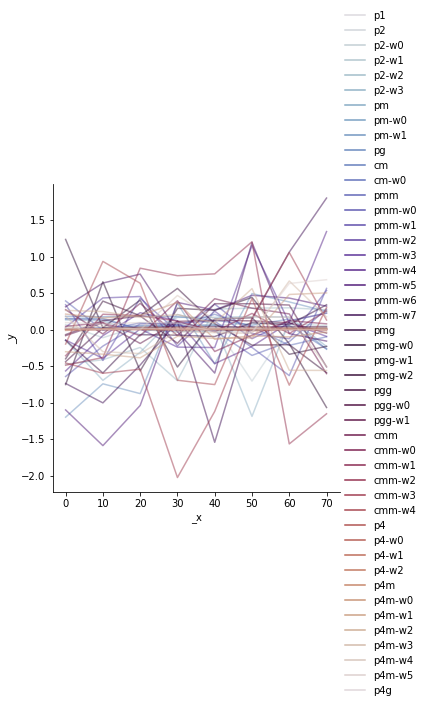

In [9]:
sns.relplot(data=df.loc[::10], kind="line", dashes=False, palette="twilight", alpha=0.5)

## Movie

In [ ]:
# make a movie
import moviepy.editor as editor
from moviepy.video.io.bindings import mplfig_to_npimage


def plot(traj, title='@_172135352171_', color='#333333', fps=60):
    T, N, D = traj.shape    
    fps = fps
    duration = T / fps
    dpi = 90
    fig, ax = plt.subplots(figsize=(1200 / dpi, 800 / dpi), dpi=dpi)
    points = ax.plot(traj[0,:,0], traj[0,:,1], color=color, marker='o', markeredgewidth=0.0, linestyle='None', alpha=1.0)[0]
    ax.set_facecolor('#f5f4e9')
    fig.patch.set_facecolor('#f5f4e9')
    title = ax.set_title(title, fontsize=32, color='#333333',fontname='monospace')
    ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
    ax.axis('off')
    xlim = np.quantile(traj[:,:,0], [0.1, 0.90])
    ylim = np.quantile(traj[:,:,1], [0.1, 0.90])
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    #plt.tight_layout()
    def make_frame(t):
        i = int(t  * fps)
        i = min(i, T-1)
        points.set_data(traj[i,:,0], traj[i,:,1])    
        return mplfig_to_npimage(fig)

    return editor.VideoClip(make_frame, duration=duration)
def write_video(clips, output, fps=60):
    composite = editor.concatenate(clips[:1] + [c.crossfadein(1.0) for c in clips[1:]], padding=-1, method='compose')   
    composite.write_videofile(output, fps=fps, preset='slower', ffmpeg_params=['-tune', 'animation'])

In [ ]:
c = []
titles = ['p1', 'p2', 'pm', 'pg', 'cm', 'pmm', 'pmg', 'pgg', 'cmm', 'p4', 'p4m', 'p4g', 'p3', 'p3m1', 'p31m', 'p6', 'p6m']
base_colors = ["f94144","f3722c","f8961e","f9844a","f9c74f","90be6d","43aa8b","4d908e","577590","277da1"]    
colors = ['#' + c for c in base_colors]
for i,t in enumerate(titles):
    md = run_sim(4, [20, 20], i+1)
    color = colors[i % len(colors)]
    c.append(plot(md.positions, t, color))
    wycks = len(symd.groups.load_group(i+1, 2)['specpos'])
    for j in range(wycks):
        try:
            md = run_sim(4+j+1, [20, 20], i+1, w=[1] * (j+1))
            c.append(plot(md.positions, f'{t}-w{j}', color))
        except RuntimeError as e:
            print(e)
write_video(c, 'traj.mp4')
for ci in c:
    ci.close()

In [ ]:
cd = 500 / 60
md = int(135 / cd) * cd
print('Will cut to clips of length', md)
main_clip = editor.VideoFileClip("traj.mp4")
N = int(main_clip.duration / md) + 1
print('Will write', N, 'clips')
time = 0
i = 0
for i in range(N):
    clip = main_clip.subclip(i * md, min((i + 1) * md, main_clip.duration))
    clip.write_videofile(f'traj-{i}.mp4', fps=60)#, preset='slower', ffmpeg_params=['-tune', 'animation'])
    clip.close()
